In [1]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

# import numpy as sns
# import pandas as np
# import seaborn as pd
# import matplotlib.pyplot as torch

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

from lazypredict.Supervised import LazyRegressor
from catboost import CatBoostRegressor
from sklearn.impute import KNNImputer
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, LearningCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.utils import shuffle

import pickle

import shap

import seaborn as sns
sns.set_theme()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
random_state = 42

# 1 | Загружаем все данные

In [2]:
df = pd.read_csv('data.csv', index_col=0).drop(columns=['Unnamed: 0'])
df_bac = pd.read_csv('bacterial_descriptors.csv', index_col=0)
df_drug = pd.read_csv('drug_descriptors.csv', index_col=0)

# Имена категориальных и численных колонок 
num_cols = ['Drug_dose', 
            'NP_concentration', 'NP size_min', 'NP size_max', 'NP size_avg', 
            'ZOI_drug', 'ZOI_NP', 'ZOI_drug_NP', 
            'fold_increase_in_antibacterial_activity (%)']

cat_cols = ['Bacteria', 'NP_Synthesis', 'Drug',	'Drug_class_drug_bank', 'shape', 'method', 'MDR_check']

df

,Bacteria,NP_Synthesis,Drug,Drug_class_drug_bank,Drug_dose,NP_concentration,NP size_min,NP size_max,NP size_avg,shape,method,ZOI_drug,ZOI_NP,ZOI_drug_NP,fold_increase_in_antibacterial_activity (%),MDR_check
0,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Amoxicillin,Lactams,NaN,NaN,4.00,10.00,8.00,spherical,MIC,32+,6.3,32+,NaN,1
1,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Penicillin,Carboxylic acids and derivatives,NaN,NaN,4.00,10.00,8.00,spherical,MIC,32+,6.3,32+,NaN,1
2,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Amoxicillin,Lactams,NaN,NaN,15.00,30.00,28.00,spherical,MIC,32+,25,32+,NaN,1
3,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Penicillin,Carboxylic acids and derivatives,NaN,NaN,15.00,30.00,28.00,spherical,MIC,32+,25,32+,NaN,1
4,Micrococcus luteus,green_synthesis from fungus Aspergillus flavus,Vancomycin,Carboxylic acids and derivatives,30.00,100,5.00,30.00,21.00,spherical,disc_diffusion,0,14,17+2,7.02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,Staphylococcus aureus,green_synthesis using C. zylinicum aqueous ext...,NaN,NaN,NaN,NaN,10.00,78.90,44.45,spherical,MIC,NaN,4.5,NaN,NaN,0
879,Acinetobacter baumanii,green_synthesis using C. zylinicum aqueous ext...,NaN,NaN,NaN,NaN,10.00,78.90,44.45,spherical,MIC,NaN,5.7,NaN,NaN,0
880,Enterococcus faecalis,green_synthesis using extract of Klebsiella pn...,NaN,NaN,NaN,10,20.00,20.00,20.00,spherical,disc_diffusion,NaN,10,NaN,NaN,0
881,Enterococcus faecalis,green_synthesis using extract of Klebsiella pn...,NaN,NaN,NaN,20,20.00,20.00,20.00,spherical,disc_diffusion,NaN,18,NaN,NaN,0


# 2 | Предварительная обработка data

## Очистка и предварительный анализ численных признаков

Чистим от плюсиков.

In [3]:
df['ZOI_drug'] = df['ZOI_drug'].replace('32+', '32').astype('float64')
df['ZOI_drug'].unique()

array([3.200e+01, 0.000e+00, 1.200e+01, 5.000e+02, 2.200e+01, 4.600e+01,
       4.800e+01, 4.700e+01, 4.400e+01, 3.000e+01, 2.800e+01, 2.700e+01,
       4.000e+01, 2.300e+01, 2.500e+01, 3.400e+01, 2.600e+01, 3.700e+01,
       2.900e+01, 3.600e+01, 2.000e+01, 2.100e+01, 2.400e+01, 3.100e+01,
       1.000e+03, 2.500e+02, 8.000e+00, 1.400e+01, 1.700e+01, 1.800e+01,
       7.000e+00, 3.300e+01, 2.070e+01, 1.500e+01, 1.900e+01, 2.800e+00,
       1.100e+01, 1.300e+01, 1.600e+01, 1.730e+01, 1.850e+01, 9.000e+00,
       1.000e+01, 6.400e+01,       nan, 7.500e+00, 4.600e-01, 4.000e+00,
       1.000e+00, 2.000e+00, 1.250e+02, 1.250e+00, 6.250e-01, 3.125e-01,
       2.500e-01, 3.000e-02, 2.500e+00, 1.000e-02, 5.000e-02, 1.000e-01,
       5.000e-01, 7.500e-01, 1.280e+02])

In [4]:
df['ZOI_NP'] = df['ZOI_NP'].replace('50+', '50').astype('float64')
df['ZOI_NP'].unique()

array([6.300e+00, 2.500e+01, 1.400e+01,       nan, 1.500e+01, 1.300e+01,
       6.400e+01, 1.200e+01, 1.600e+01, 1.700e+01, 2.000e+01, 1.350e+01,
       2.100e+01, 1.900e+01, 1.000e+01, 2.400e+01, 1.800e+01, 2.200e+01,
       3.200e+01, 5.000e+01, 8.000e+00, 1.250e+01, 1.000e+02, 2.500e+00,
       5.000e+00, 4.000e+00, 1.100e+01, 5.000e-01, 2.500e-01, 2.000e+00,
       1.280e+02, 3.100e-01, 9.000e-02, 4.700e-01, 6.000e+01, 1.600e+02,
       1.800e+02, 2.200e+02, 4.000e+01, 1.200e+02, 1.400e+02, 0.000e+00,
       2.600e+01, 2.700e+01, 7.000e+00, 9.000e+00, 1.460e+01, 1.560e+01,
       1.730e+01, 2.030e+01, 7.800e+00, 8.100e+00, 9.800e+00, 3.000e+01,
       3.500e+01, 6.500e+01, 8.000e+01, 2.060e+01, 2.660e+01, 1.040e+00,
       2.000e-02, 4.000e+03, 1.055e+01, 1.122e+01, 1.139e+01, 1.157e+01,
       9.260e+00, 1.430e+01, 1.530e+01, 2.800e+00, 3.100e+00, 4.500e+00,
       5.700e+00, 2.300e+01])

In [5]:
df['ZOI_drug_NP'] = df['ZOI_drug_NP'].replace({'32+': '32', '17+2': '17'}).astype('float64')
df['ZOI_drug_NP'].unique()

array([3.200e+01, 1.700e+01, 1.500e+01, 6.250e+01, 5.000e+01, 4.800e+01,
       4.700e+01, 4.400e+01, 4.200e+01, 4.100e+01, 4.000e+01, 3.900e+01,
       3.800e+01, 3.700e+01, 3.600e+01, 3.500e+01, 3.400e+01, 3.125e+01,
       3.100e+01, 3.000e+01, 2.900e+01, 2.800e+01, 2.700e+01, 2.600e+01,
       2.500e+01, 2.400e+01, 2.300e+01, 2.200e+01, 2.150e+01, 2.100e+01,
       2.080e+01, 2.000e+01, 1.990e+01, 1.900e+01, 1.850e+01, 1.800e+01,
       1.600e+01, 1.530e+01, 1.475e+01, 1.433e+01, 1.400e+01, 1.300e+01,
       1.288e+01, 1.280e+01, 1.276e+01, 1.257e+01, 1.245e+01, 1.200e+01,
       1.167e+01, 1.164e+01, 1.145e+01, 1.143e+01, 1.100e+01, 1.098e+01,
       1.062e+01, 1.034e+01, 1.000e+01, 9.740e+00, 9.000e+00, 8.000e+00,
       7.810e+00, 7.000e+00, 4.800e+00, 4.000e+00, 2.000e+00, 1.750e+00,
       1.000e+00, 9.700e-01, 8.000e-01, 6.000e-01, 5.000e-01, 4.000e-01,
       3.000e-01, 2.500e-01, 1.250e-01, 1.000e-01, 3.000e-02, 0.000e+00,
             nan])

В столбце ```NP_concentration``` обнаружились записи, где сразу три числа

In [6]:
df['NP_concentration'].unique()

array([nan, '100', '30', '170/85/42.5', '170/85/42.33', '170/85/42.15',
       '170/85/42.24', '170/85/42.20', '170/85/42.11', '10',
       '170/85/42.27', '170/85/42.13', '170/85/42.34', '170/85/42.8',
       '170/85/42.32', '170/85/42.23', '170/85/42.12', '170/85/42.25',
       '170/85/42.10', '170/85/42.29', '170/85/42.26', '170/85/42.28',
       '170/85/42.16', '170/85/42.6', '170/85/42.31', '170/85/42.9',
       '170/85/42.19', '170/85/42.18', '170/85/42.30', '170/85/42.17',
       '170/85/42.21', '170/85/42.14', '20', '170/85/42.7',
       '170/85/42.22', '50', '25', '102', '104', '170', '85', '42.5',
       '21.25', '10.625', '2.65', '1.33', '0.66', '0.31', '1000', '500',
       '300'], dtype=object)

Проверим, что нет ничего особенного в строках с ними

In [7]:
df[df['NP_concentration'] == '170/85/42.29']

,Bacteria,NP_Synthesis,Drug,Drug_class_drug_bank,Drug_dose,NP_concentration,NP size_min,NP size_max,NP size_avg,shape,method,ZOI_drug,ZOI_NP,ZOI_drug_NP,fold_increase_in_antibacterial_activity (%),MDR_check
73,Salmonella enterica,green_synthesis using Ulva fasciata,Neomycin,NC,30.00,170/85/42.29,14.45,15.55,15.00,spherical,disc_diffusion,14.00,NaN,28.00,NaN,0


Возможно, это проведено три измерения с разными концентрациями НЧ, и в таргетные ячейки записано среднее. Добавим столбец "эксперимент с разными концентрациями": ```bool```.
Но проще просто выкинуть

In [8]:
'''df['various_conc_tested'] = np.array(['/' in str(x) for x in df['NP_concentration']])
df.loc[df['various_conc_tested'] == True, 'NP_concentration'] = 170
df['various_conc_tested'].value_counts()'''

df = df[~(df['NP_concentration'].astype(str).str.contains('170/85'))]
df['NP_concentration'] = df['NP_concentration'].astype('float64')

In [9]:
df['NP_concentration'].unique()

array([       nan, 1.0000e+02, 3.0000e+01, 1.0000e+01, 2.0000e+01,
       5.0000e+01, 2.5000e+01, 1.0200e+02, 1.0400e+02, 1.7000e+02,
       8.5000e+01, 4.2500e+01, 2.1250e+01, 1.0625e+01, 2.6500e+00,
       1.3300e+00, 6.6000e-01, 3.1000e-01, 1.0000e+03, 5.0000e+02,
       3.0000e+02])

Заменим NP size min/max на размах

In [10]:
df['min_max_NP_size'] = df['NP size_max'] - df['NP size_min']
df.drop(columns=['NP size_max', 'NP size_min'], inplace=True)

df.rename(columns={'NP size_avg': 'avg_NP_size'}, inplace=True)

num_cols.pop(num_cols.index('NP size_max'))
num_cols.pop(num_cols.index('NP size_min'))
num_cols.pop(num_cols.index('NP size_avg'))
num_cols.append('avg_NP_size')

In [11]:
df.dtypes

Bacteria                                        object
NP_Synthesis                                    object
Drug                                            object
Drug_class_drug_bank                            object
Drug_dose                                      float64
NP_concentration                               float64
avg_NP_size                                    float64
shape                                           object
method                                          object
ZOI_drug                                       float64
ZOI_NP                                         float64
ZOI_drug_NP                                    float64
fold_increase_in_antibacterial_activity (%)    float64
MDR_check                                        int64
min_max_NP_size                                float64
dtype: object

Численные фичи в порядке

## Очистка и предварительный анализ строковых признаков

Ищем проблемы в строковых фичах:

In [12]:
for i in cat_cols:
    print(i, ':\n', sorted(df[i].dropna().unique().tolist()),'\n')

Bacteria :
 ['Acinetobacter baumanii', 'Actinobacillus pleuropneumoniae ', 'Bacillus cereus', 'Bacillus spp.        ', 'Bacillus subtilis', 'Candida albicans', 'Candida glabrata', 'Candida glochares', 'Candida saitoana', 'Enterobacter cloacae ', 'Enterococcus faecalis', 'Enterococcus faecium', 'Escherichia coli', 'Haemophilus influenzae', 'Klebsiella pneumoniae', 'Klebsiella sp.', 'Listeria monocytogenes', 'Micrococcus luteus', 'Neisseria mucosa', 'Pasteurella Multocida', 'Proteus mirabilis', 'Proteus sp.', 'Proteus vulgaris', 'Pseudomonas aeruginosa', 'Pseudomonas koreensis', 'Salmonella  typhi', 'Salmonella Paratyphi', 'Salmonella enterica', 'Salmonella typhimurium ', 'Serratia marcescens', 'Serratia odorifera', 'Staphylococcus aureus', 'Staphylococcus epidermidis', 'Streptococcus mutans', 'Streptococcus pneumoniae', 'Streptococcus uberis', 'Vibrio cholerae', 'Vibrio parahaemolyticus'] 

NP_Synthesis :
 ['chem_synthesis', 'chem_synthesis (purchased from Vector Vita Ltd, Novosibirsk, 

0) Куча лишних пробелов, нужен ```str.strip```

In [13]:
# strip на все строки, drug с маленькой буквы, чтобы унифицировать
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

1) Bacteria: слишком много опечаток

In [14]:
df['Bacteria'] = df['Bacteria'].replace({
    'Acinetobacter baumanii': 'Acinetobacter baumannii',
    'Bacillus spp.': 'Bacillus sp.',
    'Salmonella  typhi': 'Salmonella typhi'
})

2) NP_Synthesis: куча лишней инфы, скорее всего окажется важным зеленый/химический синтез, и то не факт

In [15]:
df['NP_Synthesis'] = df['NP_Synthesis'].replace({'chem_synthesis.*': 'chem_synthesis', 
                                                 'chemical_synthesis.*': 'chem_synthesis',
                                                 'green_synthesis.*': 'green_synthesis'}, regex=True)

3) Drug: некоторые написаны с маленькой буквы

In [16]:
df['Drug'] = df['Drug'].map(lambda x: x.lower() if isinstance(x, str) else x)

4) Drug_class_drug_bank: есть два drug'a, которые отнесены к двум классам сразу. Посмотрели глазами, решили, что можно оставить один класс, потеряем не много

In [17]:
print(df[df['Drug_class_drug_bank'] == 'Benzene and substituted derivatives; Phenol ethers'])
df['Drug_class_drug_bank'] = df['Drug_class_drug_bank'].replace('Benzene and substituted derivatives; Phenol ethers', 'Benzene and substituted derivatives')

                 Bacteria     NP_Synthesis            Drug  \
26       Escherichia coli  green_synthesis  co-trimoxazole   
31  Staphylococcus aureus  green_synthesis  co-trimoxazole   

                                 Drug_class_drug_bank  Drug_dose  \
26  Benzene and substituted derivatives; Phenol et...       2.00   
31  Benzene and substituted derivatives; Phenol et...       2.00   

    NP_concentration  avg_NP_size      shape          method  ZOI_drug  \
26             10.00        22.50  spherical  disc_diffusion     37.00   
31             10.00        22.50  spherical  disc_diffusion     36.00   

    ZOI_NP  ZOI_drug_NP  fold_increase_in_antibacterial_activity (%)  \
26     NaN        37.00                                         0.00   
31     NaN        36.00                                         0.00   

    MDR_check  min_max_NP_size  
26          0            27.00  
31          0            27.00  


Теперь все хорошо

In [18]:
for i in cat_cols:
    print(i, ':\n', sorted(df[i].dropna().unique().tolist()),'\n', len(sorted(df[i].dropna().unique().tolist())))

Bacteria :
 ['Acinetobacter baumannii', 'Actinobacillus pleuropneumoniae', 'Bacillus cereus', 'Bacillus sp.', 'Bacillus subtilis', 'Candida albicans', 'Candida glabrata', 'Candida glochares', 'Candida saitoana', 'Enterobacter cloacae', 'Enterococcus faecalis', 'Enterococcus faecium', 'Escherichia coli', 'Haemophilus influenzae', 'Klebsiella pneumoniae', 'Klebsiella sp.', 'Listeria monocytogenes', 'Micrococcus luteus', 'Neisseria mucosa', 'Pasteurella Multocida', 'Proteus mirabilis', 'Proteus sp.', 'Proteus vulgaris', 'Pseudomonas aeruginosa', 'Pseudomonas koreensis', 'Salmonella Paratyphi', 'Salmonella enterica', 'Salmonella typhi', 'Salmonella typhimurium', 'Serratia marcescens', 'Serratia odorifera', 'Staphylococcus aureus', 'Staphylococcus epidermidis', 'Streptococcus mutans', 'Streptococcus pneumoniae', 'Streptococcus uberis', 'Vibrio cholerae', 'Vibrio parahaemolyticus'] 
 38
NP_Synthesis :
 ['chem_synthesis', 'green_synthesis'] 
 2
Drug :
 ['amikacin', 'amoxicillin', 'amphoterici

## Избавляемся от NaN

In [19]:
for col in df:
    print(f'{col} - nans: {df[col].isna().sum()}')

Bacteria - nans: 0
NP_Synthesis - nans: 0
Drug - nans: 241
Drug_class_drug_bank - nans: 241
Drug_dose - nans: 306
NP_concentration - nans: 250
avg_NP_size - nans: 0
shape - nans: 0
method - nans: 0
ZOI_drug - nans: 256
ZOI_NP - nans: 412
ZOI_drug_NP - nans: 299
fold_increase_in_antibacterial_activity (%) - nans: 432
MDR_check - nans: 0
min_max_NP_size - nans: 0


### ```ZOI_drug_NP```
target, вынуждены выбросить, остается 584 сэмпла

In [20]:
df = df[~df['ZOI_drug_NP'].isna()]
print('Remaining rows:', df.shape[0])

Remaining rows: 554


### ```Drug_dose```
смотрим на значения, там сильный разброс, но явно есть порядки 1, 10 и 100, поэтому заменим его на логарифм, а для нанов применим KNN

In [21]:
df['Drug_dose'].unique()

array([  nan,  30. ,  10. , 500. ,   2. ,   5. , 100. , 300. ,  25. ,
        20. ,  50. ,   2.5,  15. ])

In [22]:
df['lg_Drug_dose'] = np.log10(df['Drug_dose'])
df.drop(columns=['Drug_dose'], inplace=True)

In [23]:
num_cols.pop(num_cols.index('Drug_dose'))
num_cols.append('lg_Drug_dose')

In [24]:
df['lg_Drug_dose'].unique()

array([       nan, 1.47712125, 1.        , 2.69897   , 0.30103   ,
       0.69897   , 2.        , 2.47712125, 1.39794001, 1.30103   ,
       1.69897   , 0.39794001, 1.17609126])

### ```NP_concentration``` 
вот такая гистограмма, можно заменить на моду.

<Axes: xlabel='NP_concentration', ylabel='Probability'>

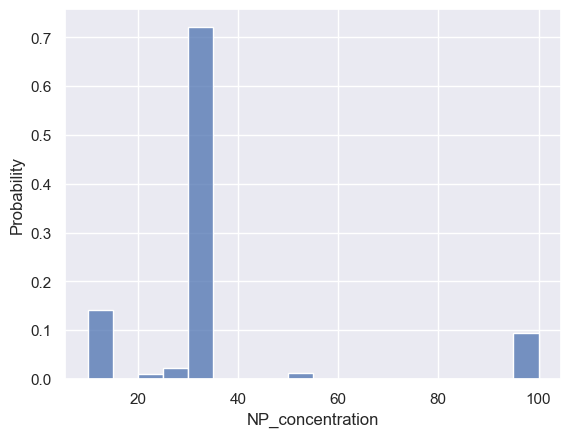

In [25]:
sns.histplot(df['NP_concentration'].dropna().astype('float32'), stat='probability', binwidth=5)

In [26]:
mode_conc = df['NP_concentration'].mode()[0]
df['NP_concentration'].fillna(mode_conc, inplace=True)
df['NP_concentration']

0      30.00
1      30.00
2      30.00
3      30.00
4     100.00
       ...  
579    30.00
580    30.00
581    30.00
582    30.00
583    30.00
Name: NP_concentration, Length: 554, dtype: float64

### ```ZOI_NP```
422/583 NaN, разумнее будет выкинуть, не глядя на распределение и важность и ни о чем не жалея

In [27]:
df.drop(columns=['ZOI_NP'], inplace=True)
num_cols.pop(num_cols.index('ZOI_NP'))

'ZOI_NP'

###  ```ZOI_drug```
Заменим по KNN, обучив на свойствах соответствующих лекарств и бактерий. Поскольку про них все известно, должно получиться хорошо.

### ```fold_increase_in_antibacterial_activity (%)```
Также используем KNN для заполнения пропусков.

Применять KNN будем после объединения баз данных. 

In [28]:
for col in df:
    print(f'{col} - nans: {df[col].isna().sum()}')
print('--------------\nRows:', df.shape[0])

Bacteria - nans: 0
NP_Synthesis - nans: 0
Drug - nans: 0
Drug_class_drug_bank - nans: 0
NP_concentration - nans: 0
avg_NP_size - nans: 0
shape - nans: 0
method - nans: 0
ZOI_drug - nans: 15
ZOI_drug_NP - nans: 0
fold_increase_in_antibacterial_activity (%) - nans: 133
MDR_check - nans: 0
min_max_NP_size - nans: 0
lg_Drug_dose - nans: 119
--------------
Rows: 554


# 3 | Предварительная обработка drug_descriptors 

In [29]:
# Выкидываем, не понадобится: есть смайлс
df_drug.drop(columns=['prefered_name', 'chemID'], inplace=True)

# Все с маленькой буквы, strip на строки для очистки
df_drug = df_drug.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df_drug['drug'] = df_drug['drug'].map(lambda x: x.lower() if isinstance(x, str) else x)
df_drug = df_drug.rename(columns={'drug': 'Drug', 'smiles': 'Smiles'})

# Откуда-то взялись дубликаты, выкидываем не думая
df_drug.drop_duplicates(inplace=True)
df_drug = df_drug.reset_index(drop=True)

Проверяем, что в БД drug есть все вещества, какие есть в data

In [30]:
drugs_in_drugs = set(df_drug.Drug.unique())
drugs_in_data = set(df.Drug.unique())
drugs_in_data.difference(drugs_in_drugs)

{'neomycin'}

Не хватает неомицина, добавим его вручную (SMILES с учетом хиральности из PubChem)

In [31]:
Neomycin = {
    'Drug': ['neomycin'],
    'Smiles': [
        'C1[C@H]([C@@H]([C@H]([C@@H]([C@H]1N)O[C@@H]2[C@@H]([C@H]([C@@H]([C@H](O2)CN)O)O)N)O[C@H]3[C@@H]([C@@H]([C@H](O3)CO)O[C@@H]4[C@@H]([C@H]([C@@H]([C@@H](O4)CN)O)O)N)O)O)N'
    ]
}
row_to_append = pd.DataFrame(Neomycin)
df_drug = pd.concat([row_to_append, df_drug]).reset_index(drop=True)

## Подгрузка дополнительных признаков
 1. pKa: вычисляли с помощью J. Chem. Inf. Mod. 61(1) http://dx.doi.org/10.1021/acs.jcim.1c00075 - нейросеть, ее валидация R^2 0.75-0.95 в зависимости от основности/кислотности молекулы 

In [32]:
pKa = pd.read_csv('pKa.csv', sep=';')
pKa['Name'] = pKa['Name'].map(lambda x: x.lower() if isinstance(x, str) else x)

df_drug = pd.merge(df_drug, pKa, left_on='Drug', right_on='Name').drop(columns=['Name'])

2. Пишем функцию, чтобы легко добавлять дескрипторы из RDKit

In [33]:
def add_desc_to_df(df: pd.DataFrame, desc: list):
    '''
    Add column with descriptors values to df
    
    Parameters
    ----------
    df: pd.DataFrame

    desc: list[str]
    '''

    calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc)
    desc_df = pd.DataFrame(
        df['Smiles'].map(lambda x: calc.CalcDescriptors(Chem.MolFromSmiles(x))).to_list()
    )
    desc_df.columns = desc
    return df.join(desc_df)

Добавляем дескрипторы, см. ```descs_to_add```.
Почитали статьи про действие антибиотиков: 

In [34]:
descs_to_add = [
    'LabuteASA', 'NumHDonors', 'NumHAcceptors', 
    'MolLogP', 'MolWt', 'Chi0', 'RingCount', 'TPSA',
    'NumAliphaticRings', 'NumAromaticRings', 'NumAromaticHeterocycles',
    'MinPartialCharge', 'MaxPartialCharge', 'BertzCT'
]

df_drug = add_desc_to_df(df_drug, descs_to_add)

# 4 | Предварительная обработка bacterial_descriptors

Ищем бактерии, отсутствующие в df_bac и присутствующие в data

In [35]:
df_bac = df_bac.applymap(lambda x: x.strip() if isinstance(x, str) else x)
print(set(df['Bacteria'].unique()) - set(df_bac['Bacteria'].unique()))

# всего три строки с ними, дропаем
print(df[(df['Bacteria'] == 'Candida glochares') | (df['Bacteria'] == 'Salmonella Paratyphi')].shape)
df = df[~((df['Bacteria'] == 'Candida glochares') | (df['Bacteria'] == 'Salmonella Paratyphi'))]

{'Salmonella Paratyphi', 'Candida glochares'}
(3, 14)


Обнаружилась неправильно названная бактерия, первая (90371) гуглится, вызывает тиф и является сальмонеллой, а вторая (615) даже не сальмонелла, гуглим и переименовываем

In [36]:
df_bac[df_bac.duplicated(subset='Bacteria', keep=False)]

,Bacteria,kingdom,subkingdom,clade,phylum,class,order,family,genus,species,gram,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level,isolated_from
Tax_id,,,,,,,,,,,,,,,,,
['90371'],Salmonella typhimurium,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Salmonella,Salmonella enterica,n,6.00,39.00,72.00,37,2,meat
['615'],Salmonella typhimurium,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Yersiniaceae,Serratia,Serratia marcescens,n,2.00,7.00,12.00,30,2,water


In [37]:
df_bac.loc["['615']", 'Bacteria'] = 'Serratia marcescens'

Оставляем только тех бактерий, которые есть в data

In [38]:
df_bac = df_bac[df_bac['Bacteria'].isin(df['Bacteria'].unique())]

## Избавляемся от NaN

In [39]:
print(df_bac.shape)
for col in df_bac:
    print(f'{col} - nans: {df_bac[col].isna().sum()}')

(32, 17)
Bacteria - nans: 0
kingdom - nans: 0
subkingdom - nans: 29
clade - nans: 20
phylum - nans: 0
class - nans: 0
order - nans: 0
family - nans: 0
genus - nans: 0
species - nans: 0
gram - nans: 3
min_Incub_period, h - nans: 1
avg_Incub_period, h - nans: 0
max_Incub_period, h - nans: 1
growth_temp, C - nans: 0
biosafety_level - nans: 0
isolated_from - nans: 0


Столбцы ```subkingom``` и ```clade``` дропаем из-за пропусков

In [40]:
df_bac.drop(columns=['subkingdom', 'clade'], inplace=True)

```gram```: заполним nan согласно NCBI - базе данных с бактериями

In [41]:
df_bac[df_bac.gram.isna()]

,Bacteria,kingdom,phylum,class,order,family,genus,species,gram,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level,isolated_from
Tax_id,,,,,,,,,,,,,,,
['5476'],Candida albicans,Fungi,Ascomycota,Saccharomycetes,Saccharomycetales,Debaryomycetaceae,Candida,Candida albicans,NaN,48.00,84.00,120.00,37,2,mouth
['5478'],Candida glabrata,Fungi,Ascomycota,Saccharomycetes,Saccharomycetales,Saccharomycetaceae,Nakaseomyces,Candida glabrata,NaN,24.00,36.00,48.00,37,2,blood
['45582'],Candida saitoana,Fungi,Ascomycota,Saccharomycetes,Saccharomycetales,Debaryomycetaceae,Candida glaebosa,Candida saitoana,NaN,48.00,84.00,120.00,37,1,food


In [42]:
df_bac.loc[df_bac.gram.isna(), 'gram'] = 'p'

```min/max_Incub_period```: Заполним nan и некорректные значение модой

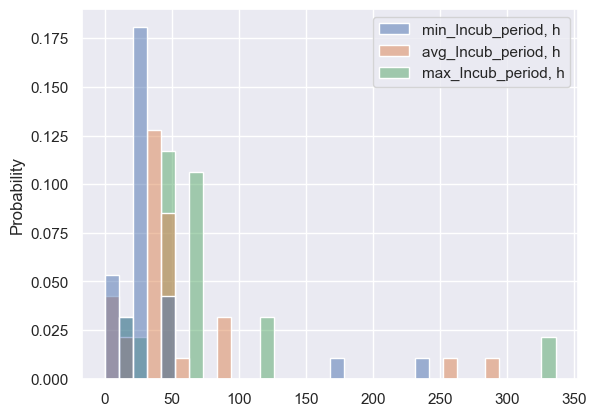

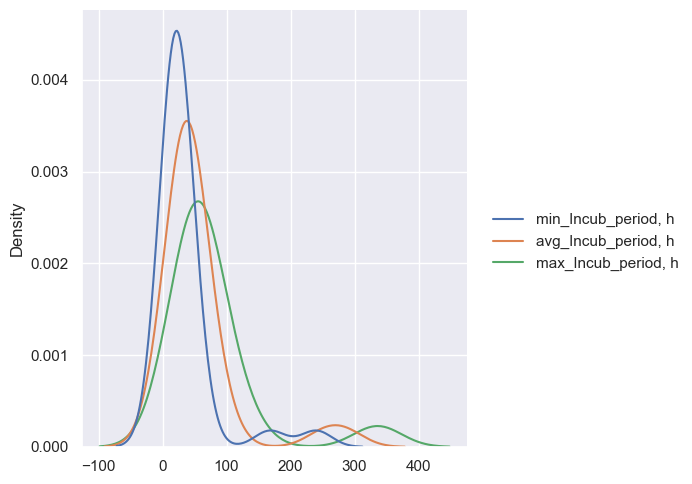

In [43]:
sns.histplot(data=df_bac[['min_Incub_period, h', 'avg_Incub_period, h', 'max_Incub_period, h']], stat='probability')

sns.displot(data=df_bac[['min_Incub_period, h', 'avg_Incub_period, h', 'max_Incub_period, h']], kind='kde')

In [44]:
df_bac[df_bac['min_Incub_period, h'].isna()]

,Bacteria,kingdom,phylum,class,order,family,genus,species,gram,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level,isolated_from
Tax_id,,,,,,,,,,,,,,,
['618'],Serratia odorifera,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Yersiniaceae,Serratia,Serratia odorifera,n,NaN,0.00,NaN,30,1,soil


In [45]:
df_bac.loc[df_bac['min_Incub_period, h'].isna(), 'min_Incub_period, h'] = df_bac['min_Incub_period, h'].mode()[0]
df_bac.loc[df_bac['max_Incub_period, h'].isna(), 'max_Incub_period, h'] = df_bac['max_Incub_period, h'].mode()[0]
df_bac.loc[df_bac['avg_Incub_period, h'].isna(), 'avg_Incub_period, h'] = df_bac['avg_Incub_period, h'].mode()[0]

## Думаем над фичами

Три коррелирующих числа (min max и avg время инкубации) нам ни к чему, но можно посчитать "размах" - вдруг он окажется полезным

In [46]:
df_bac['min_max_Incub_period'] = df_bac['max_Incub_period, h'] - df_bac['min_Incub_period, h']
df_bac.drop(columns=['max_Incub_period, h', 'min_Incub_period, h'], inplace=True)
df_bac = df_bac.rename(columns={'avg_Incub_period, h': 'avg_Incub_period'})

Обнаружилась корреляция ```min_max_Incub_period``` с ```avg_Incub_period```, но график выглядит не так уж страшно линейным, поэтому попробуем.

<Axes: >

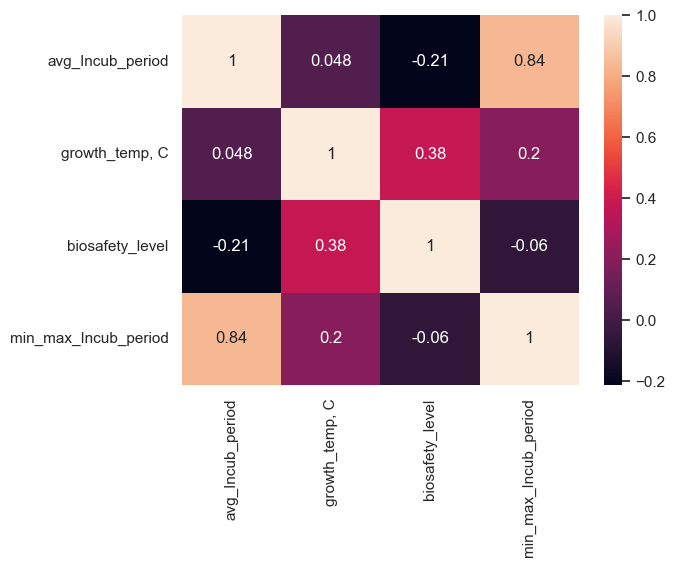

In [47]:
sns.heatmap(df_bac.corr(numeric_only=True), annot=True)

Размах имеет слишком большую кореляцию, придется выкинуть :(

In [48]:
df_bac.drop(columns=['min_max_Incub_period'], inplace=True)

# 5 | Слияние трех баз данных в одну

In [49]:
df.drop_duplicates(inplace=True)
print(df.shape)


df = df.merge(df_bac, on='Bacteria', how='left')


df = df.merge(df_drug, on='Drug', how='left')


df.drop_duplicates(inplace=True)
print(df.shape)

(547, 14)
(547, 42)


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 42 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Bacteria                                     547 non-null    object 
 1   NP_Synthesis                                 547 non-null    object 
 2   Drug                                         547 non-null    object 
 3   Drug_class_drug_bank                         547 non-null    object 
 4   NP_concentration                             547 non-null    float64
 5   avg_NP_size                                  547 non-null    float64
 6   shape                                        547 non-null    object 
 7   method                                       547 non-null    object 
 8   ZOI_drug                                     533 non-null    float64
 9   ZOI_drug_NP                                  547 non-null    float64
 10  fo

# 6 | Добиваем NaNы

Для оставшихся (столбцы ```ZOI_drug, fold_increase.., lg_Drug_dose ```) применяем KNN, обучая его по всей таблице, за исключением систематики бактерий и класса препарата (слишком много лишних столбцов с учетом encoding).

Создадим дополнительную таблицу для обучения KNN

In [51]:
cols_to_drop = [
    'isolated_from', 'Smiles', 'species', 'genus', 'family', 'order', 'class',
    'phylum', 'kingdom', 'Drug_class_drug_bank'
]

df_dummy = deepcopy(df)
df_dummy = df_dummy.drop(columns=cols_to_drop)

df_dummy = pd.get_dummies(df_dummy, drop_first=True)

In [52]:
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 98 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   NP_concentration                             547 non-null    float64
 1   avg_NP_size                                  547 non-null    float64
 2   ZOI_drug                                     533 non-null    float64
 3   ZOI_drug_NP                                  547 non-null    float64
 4   fold_increase_in_antibacterial_activity (%)  419 non-null    float64
 5   MDR_check                                    547 non-null    int64  
 6   min_max_NP_size                              547 non-null    float64
 7   lg_Drug_dose                                 432 non-null    float64
 8   avg_Incub_period                             547 non-null    float64
 9   growth_temp, C                               547 non-null    int64  
 10  bi

In [53]:
imp = KNNImputer()
df_dummy = imp.fit_transform(df_dummy)

df_dummy = pd.DataFrame(df_dummy, columns=imp.get_feature_names_out())

In [54]:
f'Total NaNs: {df_dummy.isna().sum().sum()}'

'Total NaNs: 0'

Пока что будем работать с df_dummy

# 7 | Выбросы, корреляции и анализ 

In [55]:
num_cols_final = deepcopy(num_cols)
num_cols_final.extend(descs_to_add)
num_cols_final.append('pKa')

<Axes: >

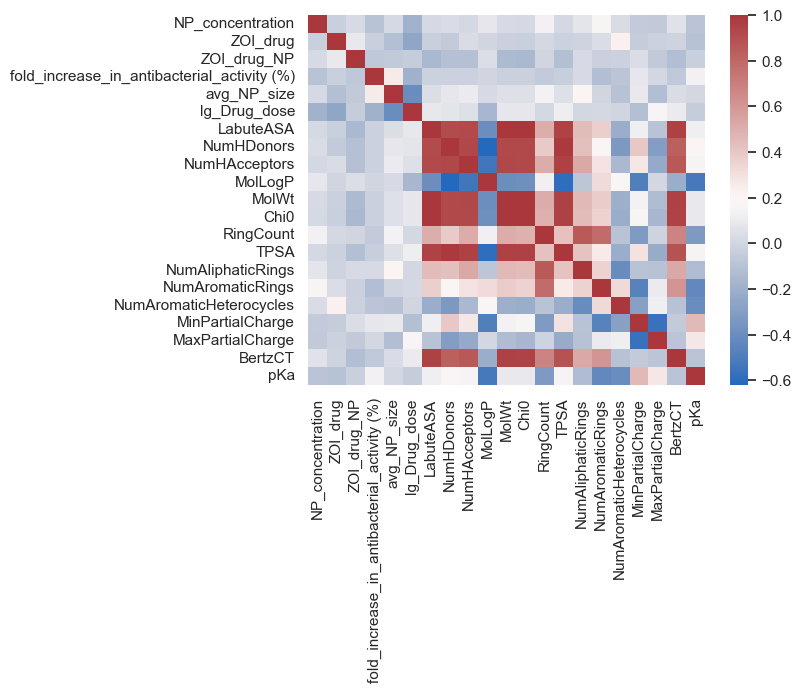

In [56]:
sns.heatmap(df_dummy[num_cols_final].corr(), cmap='vlag')
# df_dummy[num_cols_final].corr()[df_dummy[num_cols_final].corr() > 0.7]

--------------------------------! Внимание, медленная ячейка !-----------------------------

Сильно коррелируют столбцы дескрипторов, которые мы подгрузили. Перестарались, отменяем :)

In [57]:
last_drop = ['LabuteASA', 'MolWt', 'Chi0', 'NumHDonors', 'TPSA']
df_dummy.drop(columns=last_drop)
for col in last_drop:
    num_cols_final.remove(col)

<Axes: >

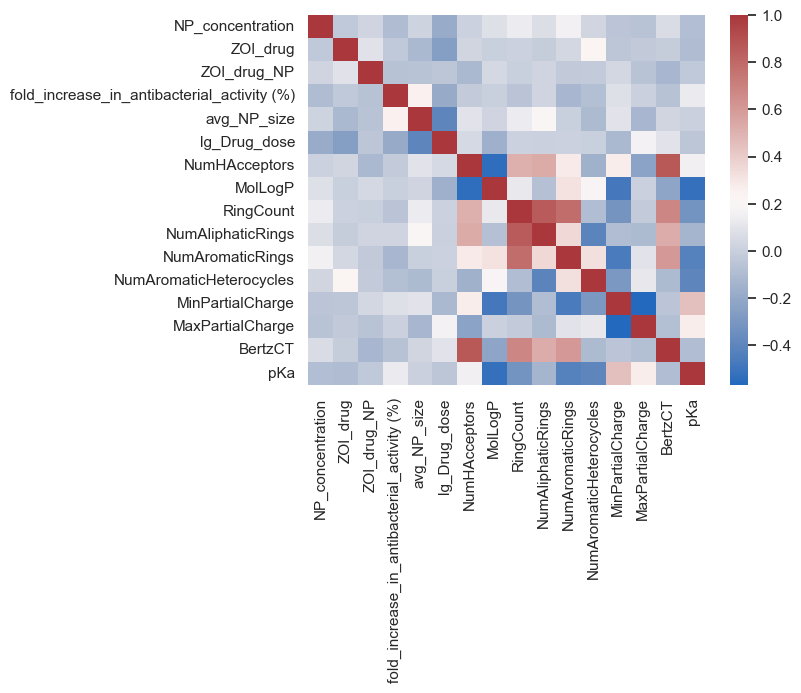

In [58]:
sns.heatmap(df_dummy[num_cols_final].corr(), cmap='vlag')

Красота! Остается посмотреть на распределения и pairplot

In [59]:
# plot = sns.pairplot(df_dummy[num_cols_final], diag_kind='kde')
# plot.savefig('pairplot.png')

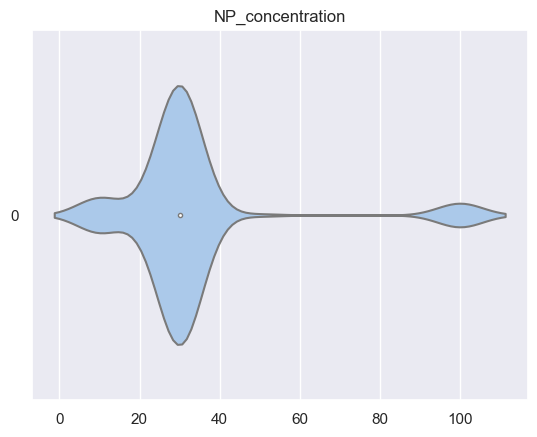

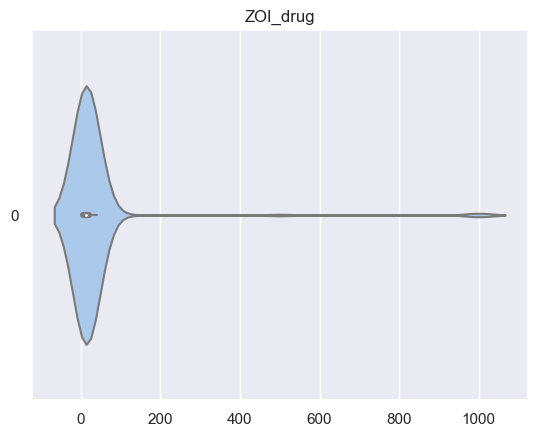

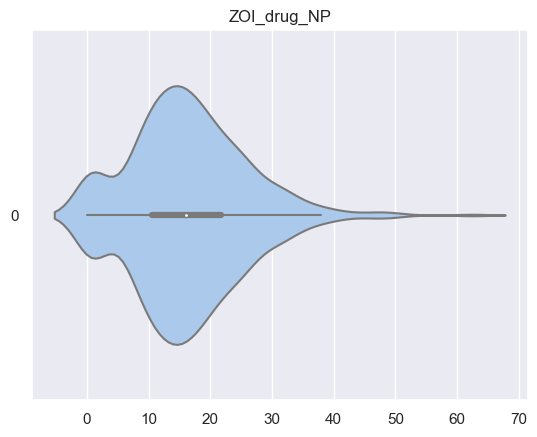

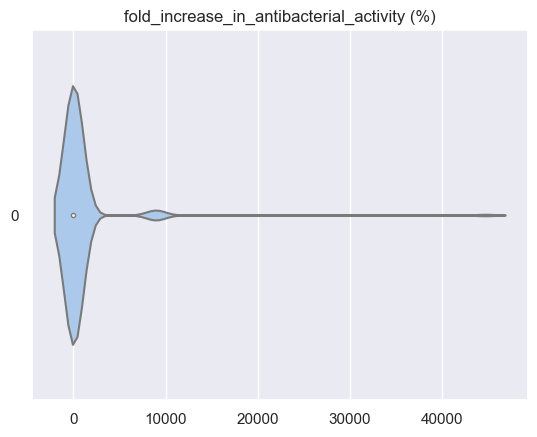

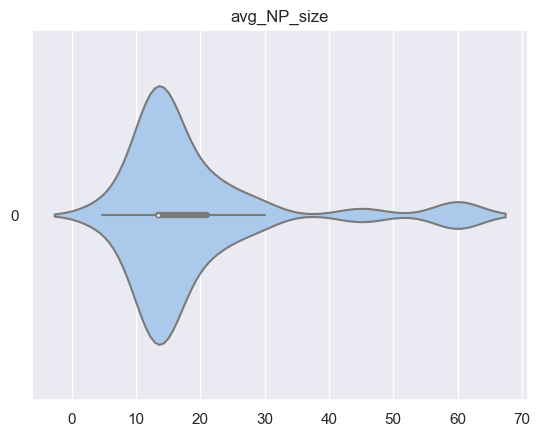

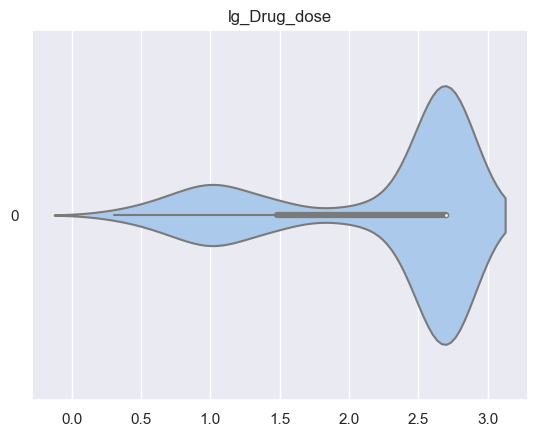

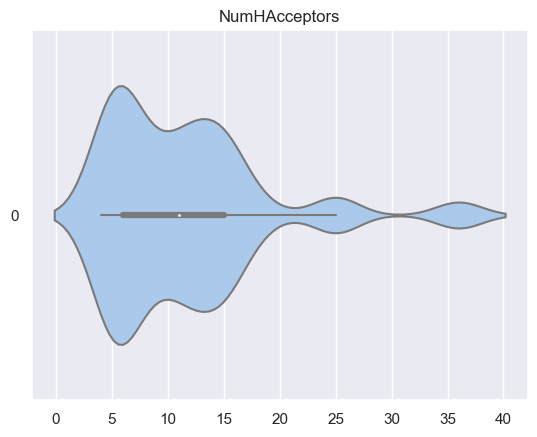

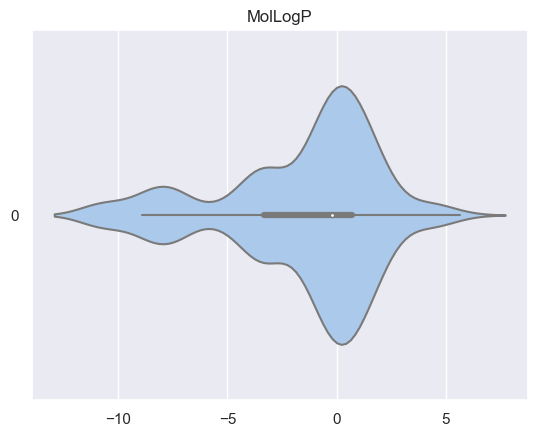

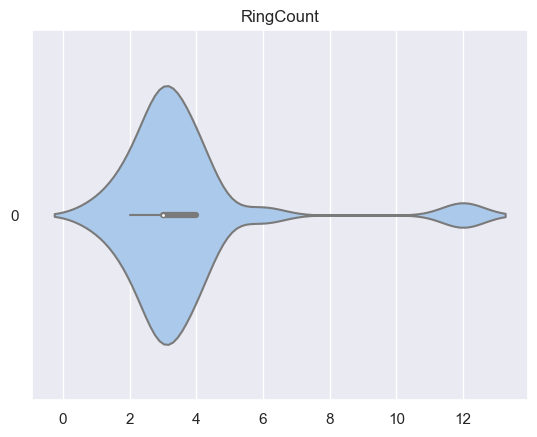

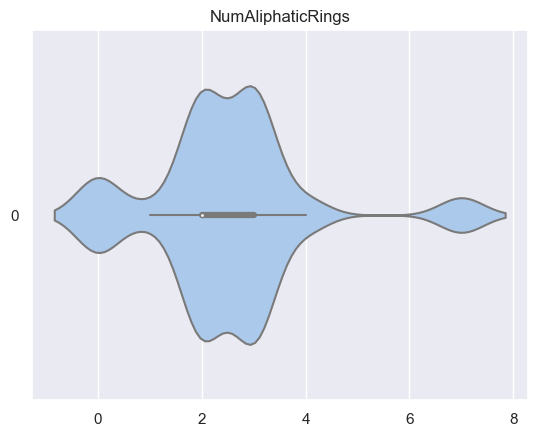

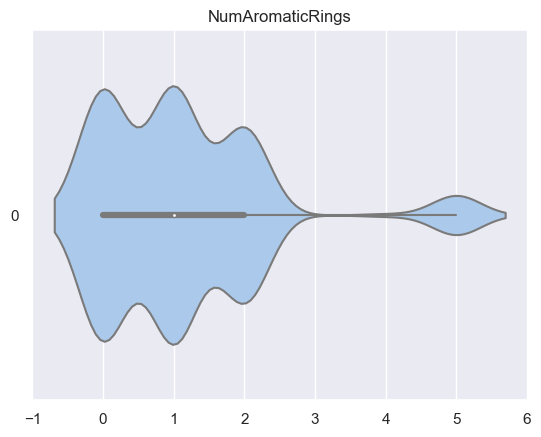

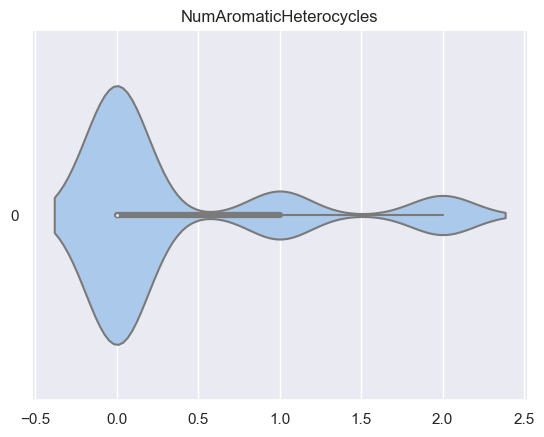

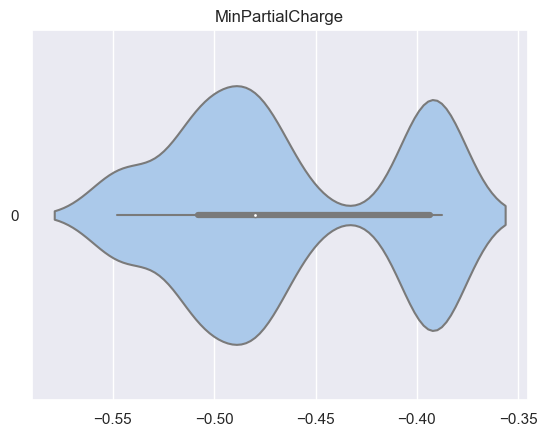

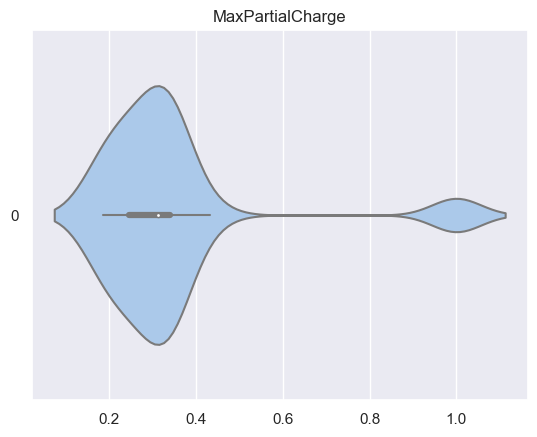

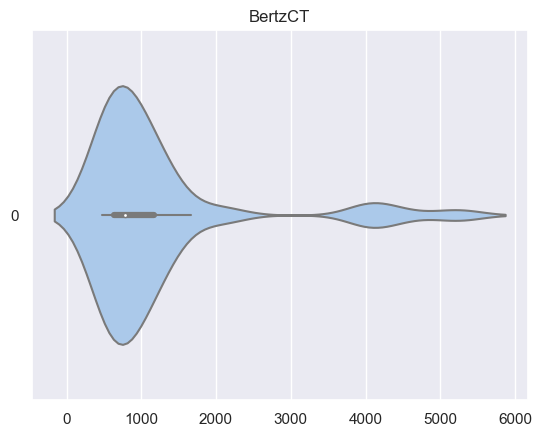

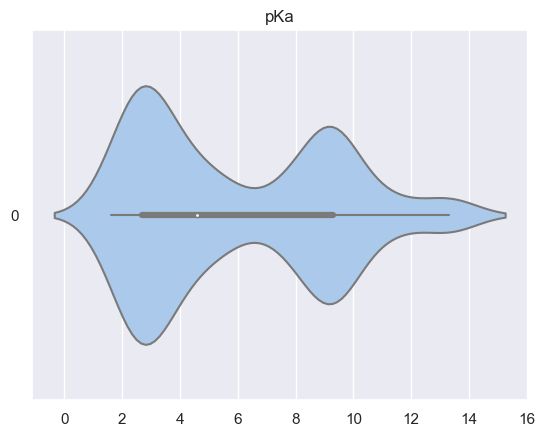

In [60]:
for col in num_cols_final:
    sns.violinplot(df_dummy[col], orient='h', width=0.7, palette='pastel')
    plt.title(col)
    plt.show()

Что-то странное с ```fold_increase``` и ```ZOI_drug```

In [61]:
for col, thresh in zip(['fold_increase_in_antibacterial_activity (%)', 'ZOI_drug'], [12, 80]):
    print(f'Column {col}, above {thresh}: {df_dummy[df_dummy[col] > thresh].shape[0]}')
    _med = df_dummy[col].median()
    df_dummy.loc[df_dummy[col] > thresh, col] = _med
    assert df_dummy[df_dummy[col] > thresh].shape[0] == 0

Column fold_increase_in_antibacterial_activity (%), above 12: 24
Column ZOI_drug, above 80: 12


Переносим новые значения в data

In [62]:
cols_to_fill = ['ZOI_drug', 'fold_increase_in_antibacterial_activity (%)', 'lg_Drug_dose']
df.loc[:, cols_to_fill] = df_dummy[cols_to_fill]
df.isna().sum().sum()

0

In [63]:
def code_and_onehot(df: pd.DataFrame, cols_to_drop: list = []):

    df_codes = deepcopy(df.drop(columns=cols_to_drop))
    df_onehot = deepcopy(df.drop(columns=cols_to_drop))

    for col in df.drop(columns=cols_to_drop):
        if df[col].dtype == object:
            df_codes[col] = pd.Categorical(df[col])
            df_codes[col] = df_codes[col].cat.codes

    df_onehot = pd.get_dummies(df_onehot, drop_first=True)
    
    return df_codes, df_onehot

In [64]:
cols_to_drop = ['Smiles']
df_codes, df_onehot = code_and_onehot(df, cols_to_drop)

In [65]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)

for test_df, name in zip([df_codes, df_onehot], ['----- df_codes -----\n', '\n\n----- df_onehot -----\n']):
    print(f'{name}')
    X_train, X_test, y_train, y_test = train_test_split(
        test_df.drop(columns=['ZOI_drug_NP']), test_df['ZOI_drug_NP'], random_state=random_state,
        test_size=0.25    
    )
    models, predictions = reg.fit(X_train, X_test, y_train, y_test)
    print(models)

----- df_codes -----



100%|██████████| 42/42 [00:05<00:00,  7.94it/s]


                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          0.80       0.86  3.67        0.43
ExtraTreeRegressor                           0.76       0.83  4.00        0.02
GradientBoostingRegressor                    0.74       0.82  4.16        0.21
BaggingRegressor                             0.73       0.81  4.25        0.09
RandomForestRegressor                        0.73       0.81  4.26        0.67
XGBRegressor                                 0.72       0.80  4.32        1.20
LGBMRegressor                                0.72       0.80  4.35        0.06
HistGradientBoostingRegressor                0.71       0.80  4.40        0.26
LassoLarsIC                                  0.66       0.76  4.78        0.02
LassoLarsCV                                  0.66       0.76  4.79        0.08
TransformedTargetRegressor                   0.66   

100%|██████████| 42/42 [00:03<00:00, 12.98it/s]

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
KernelRidge                                  7.36      -2.18 17.45        0.01
PassiveAggressiveRegressor                   3.55      -0.27 11.05        0.01
GaussianProcessRegressor                     3.46      -0.23 10.87        0.02
QuantileRegressor                            3.10      -0.05 10.03        0.75
DummyRegressor                               3.02      -0.01  9.85        0.01
RANSACRegressor                              2.76       0.12  9.17        0.08
LinearSVR                                    2.57       0.21  8.68        0.02
HuberRegressor                               2.54       0.23  8.59        0.03
PoissonRegressor                             2.44       0.28  8.31        0.01
GammaRegressor                               2.35       0.32  8.04        0.01
TweedieRegressor                             2.28   

In [66]:
def get_scores_by_models(
        models: list, df: pd.DataFrame, random_state=42, test_size=0.25, 
        get_features=True, plot_features=False
):
    
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=['ZOI_drug_NP']), df['ZOI_drug_NP'], random_state=random_state,
        test_size=test_size    
    )
    
    list_best = []
    for model in models:

        pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])
        pipe.fit(X_train, y_train)
        pred = pipe.predict(X_test)

        print(f'--- {pipe["model"].__class__.__name__} ---')
        print(f'R2 score: {r2_score(y_test, pred)}')
        print(f'RMSE score: {mean_squared_error(y_test, pred) ** 0.5}')

        if get_features or plot_features:

            feature_importance = pipe["model"].feature_importances_
            sorted_idx = np.argsort(feature_importance)

            if plot_features:
                plt.figure(figsize=(8, 8))
                plt.barh(range(len(sorted_idx[-25:])), feature_importance[sorted_idx[-25:]], align='center')
                plt.yticks(range(len(sorted_idx[-25:])), np.array(X_test.columns)[sorted_idx[-25:]])
                plt.title(f'Feature Importance for {pipe["model"].__class__.__name__}');
            
            best_features = np.array(X_test.columns)[sorted_idx[-25:]]
            list_best.extend(best_features)
        
    return list_best

In [67]:
ex_tree = ExtraTreesRegressor(random_state=random_state, n_jobs=-1)
cat = CatBoostRegressor(random_state=random_state, verbose=0)

models = [ex_tree, cat]
features = {}
final_datas = []

df_codes, df_onehot = code_and_onehot(df, cols_to_drop)

for test_df, name in zip([df_codes, df_onehot], ['----- df_codes -----\n', '\n\n----- df_onehot -----\n']):
    print(f'{name}')
    list_best = get_scores_by_models(models, test_df)
    list_best = list(set(list_best))
    print(f'Best features: {len(list_best)}')
    print(f'Scores after dropping')
    list_best.append('ZOI_drug_NP')
    test_df = test_df[list_best]
    final_datas.append(test_df)
    get_scores_by_models(models, test_df)

df_codes_final, df_onehot_final = final_datas

----- df_codes -----

--- ExtraTreesRegressor ---
R2 score: 0.8594592044951634
RMSE score: 3.6705543786658033
--- CatBoostRegressor ---
R2 score: 0.8337642938629183
RMSE score: 3.9920191412010992
Best features: 30
Scores after dropping
--- ExtraTreesRegressor ---
R2 score: 0.8685475904255588
RMSE score: 3.549888680316168
--- CatBoostRegressor ---
R2 score: 0.832850001812778
RMSE score: 4.002982088493992


----- df_onehot -----

--- ExtraTreesRegressor ---
R2 score: 0.8697611048229199
RMSE score: 3.5334651349198776
--- CatBoostRegressor ---
R2 score: 0.8320837658017698
RMSE score: 4.0121466770569985
Best features: 39
Scores after dropping
--- ExtraTreesRegressor ---
R2 score: 0.8704670146621803
RMSE score: 3.523876229655385
--- CatBoostRegressor ---
R2 score: 0.8244230124704542
RMSE score: 4.1026479861466


In [68]:
def make_gridsearchCV_by_models(models_params: list, df, test_size=0.25, cv=4):
    '''
    Execute gridseacrhCV, print best parametrs and return best models

    Parametrs
    ---------
    models_params: list[model, ]
    '''
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=['ZOI_drug_NP']), df['ZOI_drug_NP'], random_state=42,
        test_size=test_size    
    )
    
    models = []
    for model in models_params:
        
        pipe = Pipeline([('scaler', StandardScaler()), ('model', model[0])])
        grid = GridSearchCV(pipe, model[1], scoring='r2', n_jobs=-1, cv=cv)
        grid.fit(X_train, y_train)

        print(f'--- Model: {pipe["model"].__class__.__name__} ---')
        print(f'Best params: {grid.best_params_}')
        print(f'Best CV R2 score: {grid.best_score_}')
        print(f'R2 score on unseen data: {r2_score(y_test, grid.best_estimator_.predict(X_test))}')
        
        models.append(grid.best_estimator_['model'])
    
    return models

In [ ]:
cat = CatBoostRegressor(random_state=random_state, verbose=0)

cat_params = {
    'model__depth':[1, 2, 3],
    'model__iterations':[500, 1000, 3000],
    'model__learning_rate':[0.1, 0.3, 0.5], 
    'model__l2_leaf_reg':[0.5, 1, 3],
}

ex_tree = ExtraTreesRegressor(random_state=random_state, n_jobs=-1)

tree_params = {
    'model__max_depth':[10, 50, 100],
    'model__n_estimators':[75, 100, 150],
    'model__criterion':['squared_error', 'absolute_error', 'friedman_mse'], 
    'model__min_samples_split':[2, 3, 4],
}

models_params = [
    [cat, cat_params],
    [ex_tree, tree_params]
]

best_models = []

for test_df, name in zip(
    [df_codes_final, df_onehot_final], 
    ['----- df_codes_final -----\n', '\n\n----- df_onehot_final -----\n']
):
    print(name)
    models = make_gridsearchCV_by_models(models_params, test_df, cv=4)
    best_models.append(models)

In [70]:
# pickle.dump(best_models, open('best_models.pkl', 'wb'))
# best_models = pickle.load(open('best_models.pkl', 'rb'))
best_models

[[<catboost.core.CatBoostRegressor at 0x1dc529ab820>,
  ExtraTreesRegressor(criterion='absolute_error', max_depth=50,
                      min_samples_split=3, n_jobs=-1, random_state=42)],
  ExtraTreesRegressor(criterion='absolute_error', max_depth=50,
                      min_samples_split=3, n_estimators=75, n_jobs=-1,
                      random_state=42)]]

In [82]:
for group_models, test_df in zip(best_models, [df_codes_final, df_onehot_final]):
    vot = VotingRegressor([('cat', group_models[0]), ('ex_tree', group_models[1])], n_jobs=-1)
    get_scores_by_models([vot], test_df, get_features=False)

--- VotingRegressor ---
R2 score: 0.8521124480679397
RMSE score: 3.7652712538759343
--- VotingRegressor ---
R2 score: 0.8388013492157591
RMSE score: 3.9310734637490317


Визуализируем работу VoitingRegressor на df_onehot_final

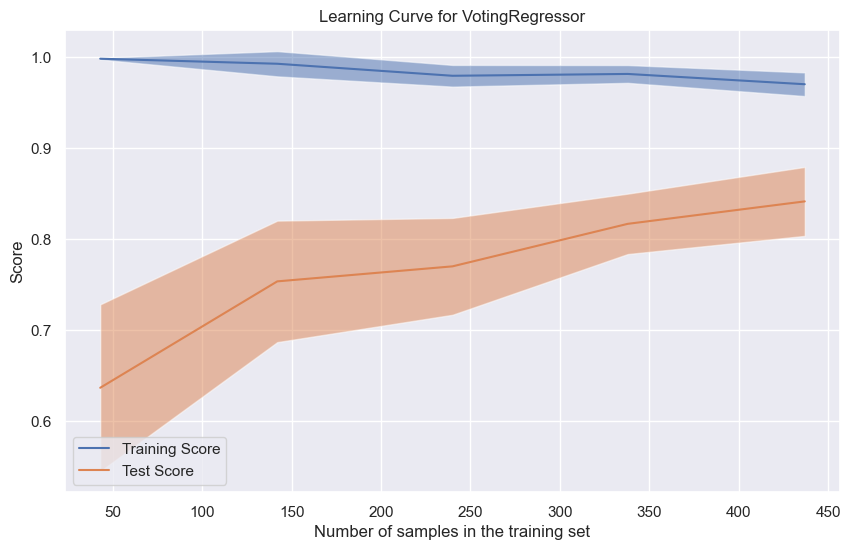

In [74]:
X, y = shuffle(df_onehot_final.drop(columns=['ZOI_drug_NP']), df_onehot_final['ZOI_drug_NP'], random_state=random_state)
fig, ax = plt.subplots(figsize=(10, 6))
pipe = Pipeline([('scaler', StandardScaler()), ('model', vot)])
LearningCurveDisplay.from_estimator(
    pipe, X=X, y=y,
    ax=ax, n_jobs=-1, 
)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {pipe['model'].__class__.__name__}");

Визуализируем feature importance для df_onehot_final

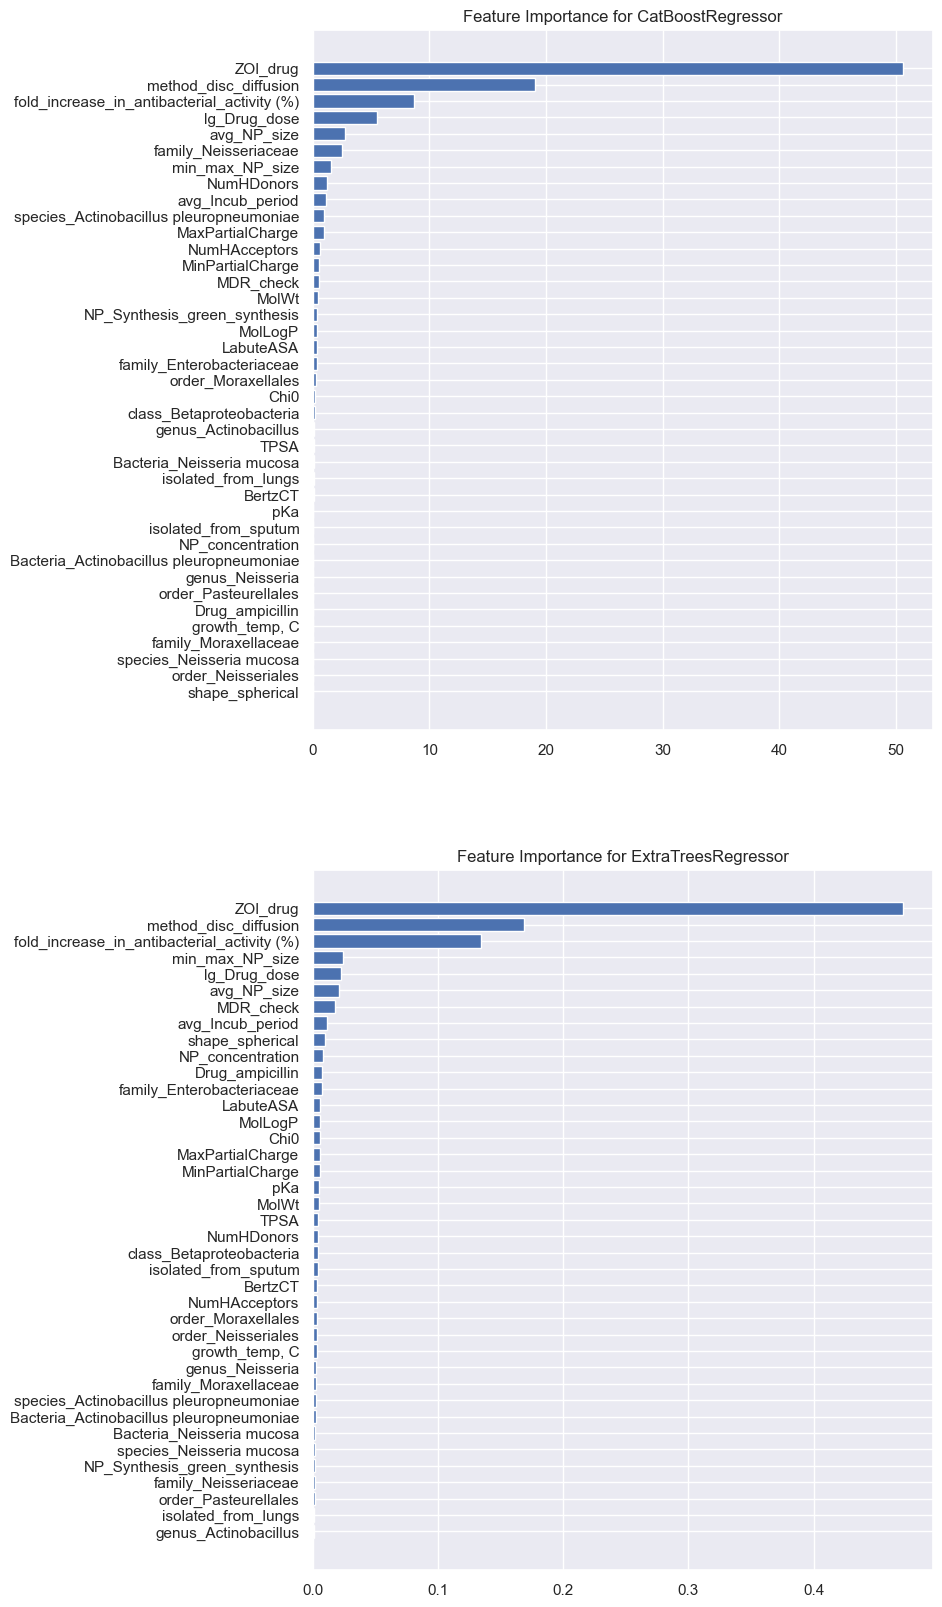

In [97]:
X_train, X_test, y_train, y_test = train_test_split(
        df_onehot_final.drop(columns=['ZOI_drug_NP']), df_onehot_final['ZOI_drug_NP'], random_state=random_state,
        test_size=0.25    
    )

fig, ax = plt.subplots(2, 1, figsize=(8, 20))

for i, model in enumerate(pipe['model'].estimators_):
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    ax[i].barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    ax[i].set_yticks(range(len(sorted_idx)), minor=False)
    ax[i].set_yticklabels(np.array(X_test.columns)[sorted_idx])
    ax[i].set_title(f'Feature Importance for {model.__class__.__name__}')
    